<a href="https://colab.research.google.com/github/Dr-Future/CSC413-project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CURRENT PREGRESS AND NOTES:

It takes 10 sec to run 1 epoch on colab

After 100 epochs of training the model performs much better. Problems is, in the area where it's supposed to be completely black or white, the model outputs opposite color pixel.

Maybe try Adam rather than SGD

I forgot to save the work after training for 100 epochs

In [1]:
!curl --remote-name -sSfL https://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
!tar xzf BSR_bsds500.tgz

Import packages

In [2]:
import os
import pickle
import sys

from PIL import Image

import argparse
import math
import time

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr
import scipy.misc
import torch
from torchvision.transforms.functional import InterpolationMode
from torchvision.transforms import Compose, Resize, ToTensor, ToPILImage
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# Utility functions

In [3]:
path = "BSR/BSDS500/data/images"

In [4]:
# Move all samples in test folder to train folder
# So that we have 400 training examples

%mv BSR/BSDS500/data/images/test/*.jpg BSR/BSDS500/data/images/train

In [5]:
class BSDS500Dataset(torch.utils.data.Dataset):
    def __init__(self, path: str, mode: str, scale: int, resize: int):
        self.path = path
        self.mode = mode # train / test / val
        self.scale = scale
        self.resize = resize
        self.file_names = [os.path.join(self.path, self.mode, file_name) for file_name in os.listdir(os.path.join(self.path, self.mode)) if file_name.endswith(".jpg")]

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, index: int):
        file_name = self.file_names[index]
        image = Image.open(file_name)

        # Convert to YUV and split the channels
        image.convert("YCbCr")
        y, u, v = image.split()

        # Calculate size
        low_res_size = self.resize // self.scale
        high_res_size = low_res_size * self.scale

        # low_res_size = [image.size[1] // self.scale, image.size[0] // self.scale]
        # high_res_size = [low_res_size[0] * self.scale, low_res_size[1] * self.scale]

        # Rescale images to square
        low_composed = Compose([
            Resize([low_res_size, low_res_size], interpolation=InterpolationMode.BICUBIC),
            ToTensor()
        ])

        high_composed = Compose([
            Resize([high_res_size, high_res_size], interpolation=InterpolationMode.BICUBIC),
            ToTensor()
        ])

        sample = { "y_low": low_composed(y).cuda(), "u_low": low_composed(u).cuda(), "v_low": low_composed(v).cuda(),
               "y_high": high_composed(y).cuda(), "u_high": high_composed(u).cuda(), "v_high": high_composed(v).cuda(),
               "high": high_composed(image).cuda() }
        return sample


# ESPCN model

In [6]:
class ESPCN_model(nn.Module):
    def __init__(self, layer1_channel, layer2_channel, upscale_factor):
        super().__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, layer1_channel, kernel_size=5, stride=1, padding=2),
            nn.Tanh()
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(layer1_channel, layer2_channel, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

        self.layer3 = nn.Sequential(
            nn.ConvTranspose2d(layer2_channel, upscale_factor ** 2, kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(upscale_factor) # This function is literally build for ESPCN
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

In [6]:
# From PA2
class UNet(nn.Module):
    def __init__(self, kernel, num_filters, num_colours, num_in_channels):
        super().__init__()

        # Useful parameters
        stride = 2
        padding = kernel // 2
        output_padding = 1

        ############### YOUR CODE GOES HERE ############### 
        self.block1 = nn.Sequential(
            nn.Conv2d(num_in_channels, num_filters, kernel, stride, padding),
            nn.BatchNorm2d(num_filters),
            nn.ReLU()
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(num_filters, 2 * num_filters, kernel, stride, padding),
            nn.BatchNorm2d(2 * num_filters),
            nn.ReLU()
        )
        self.block3 = nn.Sequential(
            nn.ConvTranspose2d(2 * num_filters, num_filters, kernel, stride, padding, output_padding, dilation=1),
            nn.BatchNorm2d(num_filters),
            nn.ReLU()
        )
        self.block4 = nn.Sequential(
            nn.ConvTranspose2d(num_filters + num_filters, num_colours, kernel, stride, padding, output_padding, dilation=1),
            nn.BatchNorm2d(num_colours),
            nn.ReLU()
        )
        self.output = nn.Conv2d(num_in_channels + num_colours, num_colours, kernel, padding=padding)
        ###################################################

    def forward(self, x):
        ############### YOUR CODE GOES HERE ###############
        a = self.block1(x)
        b = self.block2(a)
        c = self.block3(b)
        c1 = torch.cat((a, c), dim=1)
        d = self.block4(c1)
        d1 = torch.cat((x, d), dim=1)
        return self.output(d1)
        ###################################################

Code for validation

In [7]:
def run_validation_step(
    cnn,
    criterion,
    val_set,
):
    losses = []
    for i_batch, sample_batched in enumerate(val_set):
          input = sample_batched["y_low"]
          out = cnn(input)

          loss = criterion(out, sample_batched["y_high"])
          losses.append(loss.data.item())

    # if plotpath:  # only plot if a path is provided
    #     plot(
    #         xs,
    #         ys,
    #         predicted.cpu().numpy(),
    #         colours,
    #         plotpath,
    #         visualize=visualize,
    #         compare_bilinear=downsize_input,
    #     )

    val_loss = np.mean(losses)
    return val_loss

Code for training (adapted from PA2)

In [8]:
from matplotlib import transforms
from torch._C import wait

class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

def train(args, cnn=None):
    # Set the maximum number of threads to prevent crash in Teaching Labs
    # torch.set_num_threads(5)

    # Numpy random seed
    npr.seed(args.seed)

    # Save directory
    save_dir = "outputs/" + args.experiment_name

    # INPUT CHANNEL
    num_in_channels = 1

    # LOAD THE MODEL
    if cnn is None:
        cnn = ESPCN_model(64, 32, 3)

    # LOSS FUNCTION
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(cnn.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-4, nesterov=False)

    # DATA
    print("Loading data...")
    trainset = torch.utils.data.DataLoader(BSDS500Dataset(path, "train", 3, args.resize), batch_size = args.batch_size)
    testset = torch.utils.data.DataLoader(BSDS500Dataset(path, "val", 3, args.resize), batch_size = args.batch_size)

    # for item in trainset:
    #   print(item)

    # y.save("temp.jpg", "JPEG")

    # print("Transforming data...")
    # train_rgb, train_grey = process(x_train, y_train, downsize_input=args.downsize_input)
    # train_rgb_cat = get_rgb_cat(train_rgb, colours)
    # test_rgb, test_grey = process(x_test, y_test, downsize_input=args.downsize_input)
    # test_rgb_cat = get_rgb_cat(test_rgb, colours)

    # Create the outputs folder if not created already
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print("Beginning training ...")
    if args.gpu:
        cnn.cuda()
    start = time.time()

    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(args.epochs):
        # Train the Model
        cnn.train()  # Change model to 'train' mode
        losses = []

        for i_batch, sample_batched in enumerate(trainset):
          input = sample_batched["y_low"]

          optimizer.zero_grad()

          out = cnn(input)

          # print(out.size())
          # print(sample_batched["y_high"].size())

          loss = criterion(out, sample_batched["y_high"])
          loss.backward()
          optimizer.step()
          losses.append(loss.data.item())

        # plot training images
        # if args.plot:
        #     _, predicted = torch.max(outputs.data, 1, keepdim=True)
        #     plot(
        #         xs,
        #         ys,
        #         predicted.cpu().numpy(),
        #         colours,
        #         save_dir + "/train_%d.png" % epoch,
        #         args.visualize,
        #         args.downsize_input,
        #     )

        # plot training images
        avg_loss = np.mean(losses)
        train_losses.append(avg_loss)
        time_elapsed = time.time() - start
        print(
            "Epoch [%d/%d], Loss: %.4f, Time (s): %d"
            % (epoch + 1, args.epochs, avg_loss, time_elapsed)
        )

        # Evaluate the model
        # cnn.eval()  # Change model to 'eval' mode (BN uses moving mean/var).

        # val_loss = run_validation_step(
        #     cnn,
        #     criterion,
        #     testset,
        #     args.batch_size,
        #     # save_dir + "/test_%d.png" % epoch,
        # )

        # time_elapsed = time.time() - start
        # valid_losses.append(val_loss)
        # print(
        #     "Epoch [%d/%d], Val Loss: %.4f, Time(s): %.2f"
        #     % (epoch + 1, args.epochs, val_loss, time_elapsed)
        # )

    # Plot training curve
    plt.figure()
    plt.plot(train_losses, "ro-", label="Train")
    plt.plot(valid_losses, "go-", label="Validation")
    plt.legend()
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.savefig(save_dir + "/training_curve.png")

    if args.checkpoint:
        print("Saving model...")
        torch.save(cnn.state_dict(), args.checkpoint)

    return cnn

Train the model

Loading data...
Beginning training ...
Epoch [1/100], Loss: 0.1278, Time (s): 10
Epoch [2/100], Loss: 0.0551, Time (s): 20
Epoch [3/100], Loss: 0.0387, Time (s): 29
Epoch [4/100], Loss: 0.0270, Time (s): 39
Epoch [5/100], Loss: 0.0210, Time (s): 49
Epoch [6/100], Loss: 0.0165, Time (s): 60
Epoch [7/100], Loss: 0.0139, Time (s): 70
Epoch [8/100], Loss: 0.0124, Time (s): 80
Epoch [9/100], Loss: 0.0114, Time (s): 90
Epoch [10/100], Loss: 0.0109, Time (s): 100
Epoch [11/100], Loss: 0.0105, Time (s): 110
Epoch [12/100], Loss: 0.0102, Time (s): 120
Epoch [13/100], Loss: 0.0100, Time (s): 130
Epoch [14/100], Loss: 0.0097, Time (s): 139
Epoch [15/100], Loss: 0.0095, Time (s): 149
Epoch [16/100], Loss: 0.0093, Time (s): 159
Epoch [17/100], Loss: 0.0091, Time (s): 169
Epoch [18/100], Loss: 0.0089, Time (s): 179
Epoch [19/100], Loss: 0.0088, Time (s): 189
Epoch [20/100], Loss: 0.0086, Time (s): 199
Epoch [21/100], Loss: 0.0084, Time (s): 209
Epoch [22/100], Loss: 0.0083, Time (s): 218
Epoch [23/1

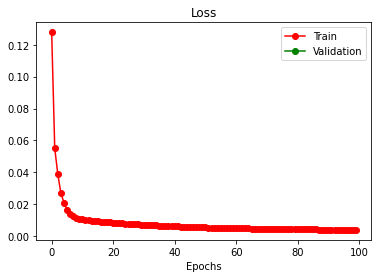

In [9]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "model.pkl",
    "model": "ESPCN",
    "resize": 481,  # Images will be transformed to [resize, resize] square image
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001,
    "batch_size": 64,
    "epochs": 100,
    "seed": 42,
    "plot": True,
    "experiment_name": "ESPCN",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = train(args)


Visualization

In [10]:
val_set = BSDS500Dataset(path, "val", 3, 481)

index = 0
cnn.eval()
for item in val_set:

  if index == 50:
    img_arr = item["y_low"]
    img = ToPILImage()(img_arr)
    img.save("in.jpg", "JPEG")

    out = cnn(img_arr.unsqueeze(0))
    out_img = ToPILImage()(out.squeeze(0))
    out_img.save("out.jpg", "JPEG")

  index += 1


Result:

Under setting batch_size = 64, epochs = 100:



In [21]:
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
    "checkpoint": "model-unet.pkl",
    "model": "unused parameter",
    "resize": 480,  # Images will be transformed to [resize, resize] square image
    "kernel": 3,
    "num_filters": 32,
    'learn_rate':0.001,
    "batch_size": 64,
    "epochs": 100,
    "seed": 42,
    "plot": True,
    "experiment_name": "UNet",
    "visualize": False,
    "downsize_input": False,
}
args.update(args_dict)
cnn = UNet(3, 32, 1, 1)
cnn = train(args, cnn)

Loading data...
Beginning training ...


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([64, 1, 480, 480])) that is different to the input size (torch.Size([64, 1, 160, 160])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: ignored